## 1. Import bibliotek i konfiguracja

In [1]:
!pip install neurokit2 pandas numpy scikit-learn matplotlib seaborn xgboost tqdm

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import neurokit2 as nk
from scipy import signal
from scipy.stats import skew, kurtosis

from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [3]:
DATA_PATH = Path("WESAD")

SUBJECTS = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17']

# Parametry sygnałów z Empatica E4
SAMPLING_RATES = {
    'BVP': 64,    # Hz
    'EDA': 4,     # Hz
    'TEMP': 4,    # Hz
    'ACC': 32     # Hz
}

# Mapowanie etykiet
LABEL_MAPPING = {
    0: 'not_defined',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation'
}

# Parametry okien czasowych (w sekundach)
WINDOW_SIZE = 60  # 60 sekund
WINDOW_SHIFT = 60  # 50% overlap

## 2. Wczytywanie danych

In [4]:
def load_subject_data(subject_id: str) -> dict:
    """
    Wczytuje dane pojedynczego uczestnika z pliku .pkl
    
    Returns:
        dict z kluczami: 'signal' (dane z wrist i chest), 'label', 'subject'
    """
    file_path = DATA_PATH / subject_id / f"{subject_id}.pkl"
    
    with open(file_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    return data

# Test wczytywania
sample_data = load_subject_data('S2')
print("🔑 Klucze w danych:", sample_data.keys())
print("\n📊 Sygnały z nadgarstka (wrist):")
for key, value in sample_data['signal']['wrist'].items():
    print(f"   {key}: shape = {value.shape}")

print(f"\n🏷️ Etykiety: shape = {sample_data['label'].shape}")
print(f"   Unikalne wartości: {np.unique(sample_data['label'])}")

🔑 Klucze w danych: dict_keys(['signal', 'label', 'subject'])

📊 Sygnały z nadgarstka (wrist):
   ACC: shape = (194528, 3)
   BVP: shape = (389056, 1)
   EDA: shape = (24316, 1)
   TEMP: shape = (24316, 1)

🏷️ Etykiety: shape = (4255300,)
   Unikalne wartości: [0 1 2 3 4 6 7]


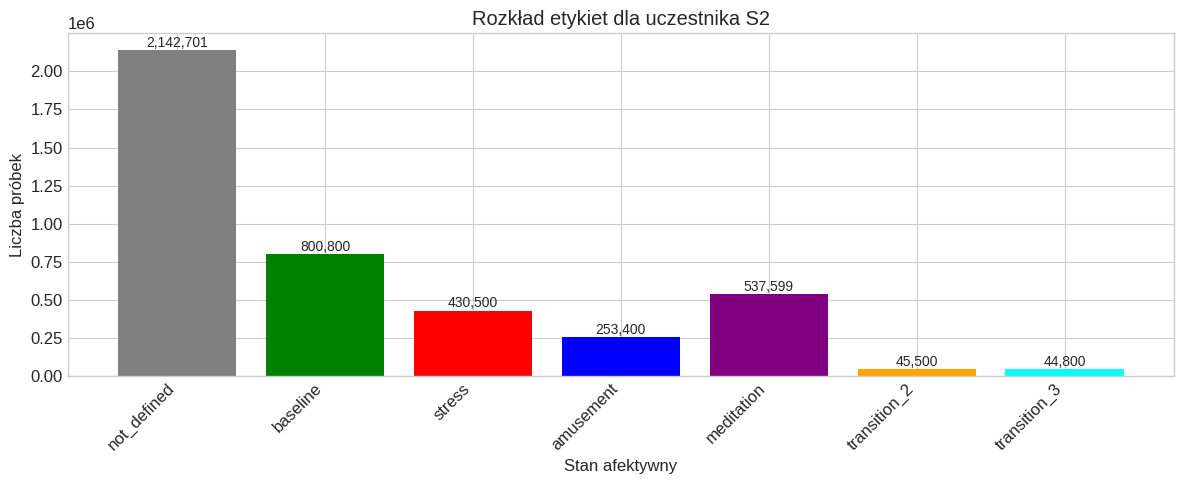

In [5]:
# Sprawdzenie rozkładu etykiet
labels = sample_data['label'].flatten()
label_counts = pd.Series(labels).value_counts().sort_index()

# Rozszerzone mapowanie (WESAD ma etykiety 0-7)
LABEL_MAPPING_FULL = {
    0: 'not_defined',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation',
    5: 'transition_1',
    6: 'transition_2',
    7: 'transition_3'
}

fig, ax = plt.subplots(figsize=(12, 5))
colors = ['gray', 'green', 'red', 'blue', 'purple', 'orange', 'cyan', 'pink']
label_names = [LABEL_MAPPING_FULL.get(i, f'unknown_{i}') for i in label_counts.index]

bars = ax.bar(label_names, label_counts.values, color=colors[:len(label_counts)])
ax.set_xlabel('Stan afektywny')
ax.set_ylabel('Liczba próbek')
ax.set_title('Rozkład etykiet dla uczestnika S2')
plt.xticks(rotation=45, ha='right')

for bar, count in zip(bars, label_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
            f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 3. Wizualizacja sygnałów

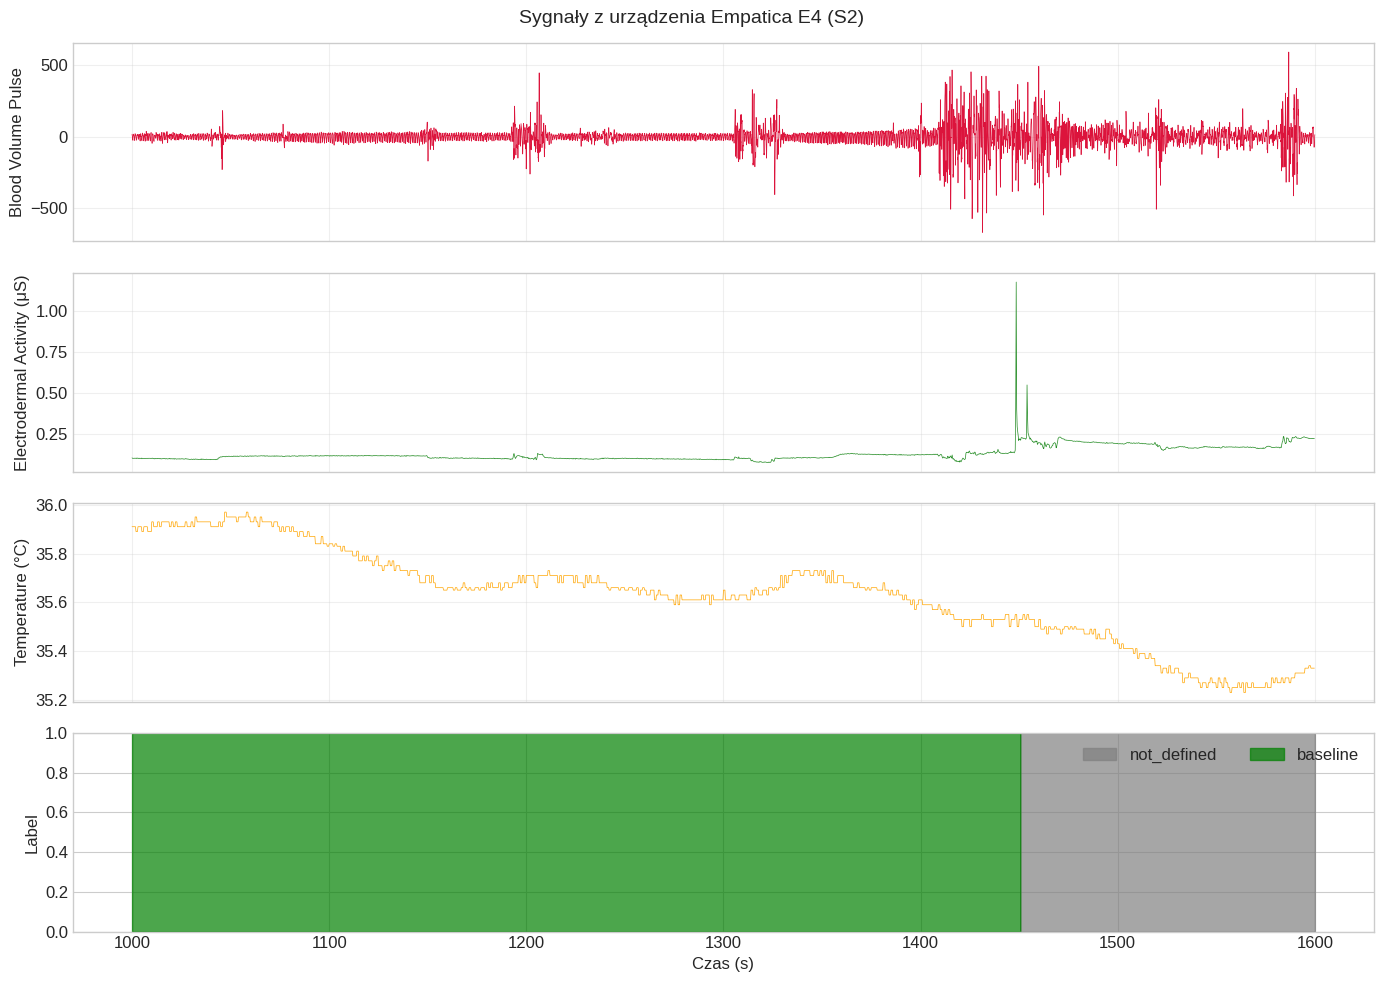

In [6]:
def plot_signals_with_labels(data: dict, start_sec: int = 0, duration_sec: int = 300):
    """
    Wizualizacja sygnałów z nadgarstka wraz z etykietami stanów
    """
    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    
    # Etykiety (700 Hz - sampling rate z chest)
    labels = data['label'].flatten()
    chest_sr = 700
    
    # Zakresy dla każdego sygnału
    signals_config = [
        ('BVP', 64, 'Blood Volume Pulse', 'crimson'),
        ('EDA', 4, 'Electrodermal Activity (μS)', 'forestgreen'),
        ('TEMP', 4, 'Temperature (°C)', 'orange'),
    ]
    
    for idx, (sig_name, sr, title, color) in enumerate(signals_config):
        sig = data['signal']['wrist'][sig_name].flatten()
        start_idx = start_sec * sr
        end_idx = min((start_sec + duration_sec) * sr, len(sig))
        
        time = np.arange(start_idx, end_idx) / sr
        axes[idx].plot(time, sig[start_idx:end_idx], color=color, linewidth=0.5)
        axes[idx].set_ylabel(title)
        axes[idx].grid(True, alpha=0.3)
    
    # Etykiety
    label_start = start_sec * chest_sr
    label_end = min((start_sec + duration_sec) * chest_sr, len(labels))
    time_labels = np.arange(label_start, label_end) / chest_sr
    
    label_colors = {0: 'gray', 1: 'green', 2: 'red', 3: 'blue', 4: 'purple'}
    for label_val in np.unique(labels[label_start:label_end]):
        mask = labels[label_start:label_end] == label_val
        axes[3].fill_between(time_labels, 0, 1, where=mask, 
                            color=label_colors[label_val], alpha=0.7,
                            label=LABEL_MAPPING[label_val])
    
    axes[3].set_ylabel('Label')
    axes[3].set_xlabel('Czas (s)')
    axes[3].legend(loc='upper right', ncol=5)
    axes[3].set_ylim(0, 1)
    
    plt.suptitle(f'Sygnały z urządzenia Empatica E4 (S2)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Wizualizacja 5 minut danych
plot_signals_with_labels(sample_data, start_sec=1000, duration_sec=600)

## 4. Ekstrakcja cech (Feature Engineering)

### Kluczowy etap projektu!
Używamy biblioteki **NeuroKit2** do automatycznej ekstrakcji cech z sygnałów fizjologicznych.

In [7]:
def extract_eda_features(eda_signal: np.ndarray, sampling_rate: int = 4) -> dict:
    """
    Ekstrakcja cech z sygnału EDA (Electrodermal Activity)
    
    Cechy:
    - Statystyczne: mean, std, min, max, range
    - Phasic/Tonic decomposition (NeuroKit2)
    - SCR peaks (Skin Conductance Responses)
    """
    features = {}
    
    try:
        # Podstawowe statystyki
        features['eda_mean'] = np.mean(eda_signal)
        features['eda_std'] = np.std(eda_signal)
        features['eda_min'] = np.min(eda_signal)
        features['eda_max'] = np.max(eda_signal)
        features['eda_range'] = features['eda_max'] - features['eda_min']
        features['eda_slope'] = (eda_signal[-1] - eda_signal[0]) / len(eda_signal)
        
        # Przetwarzanie EDA z NeuroKit2
        if len(eda_signal) > sampling_rate * 2:  # minimum 2 sekundy
            eda_processed = nk.eda_process(eda_signal, sampling_rate=sampling_rate)
            eda_df = eda_processed[0]
            
            # Składowa toniczna (baseline)
            if 'EDA_Tonic' in eda_df.columns:
                features['eda_tonic_mean'] = eda_df['EDA_Tonic'].mean()
                features['eda_tonic_std'] = eda_df['EDA_Tonic'].std()
            
            # Składowa fazowa (reakcje)
            if 'EDA_Phasic' in eda_df.columns:
                features['eda_phasic_mean'] = eda_df['EDA_Phasic'].mean()
                features['eda_phasic_std'] = eda_df['EDA_Phasic'].std()
                features['eda_phasic_max'] = eda_df['EDA_Phasic'].max()
            
            # Liczba pików SCR (Skin Conductance Response)
            if 'SCR_Peaks' in eda_df.columns:
                features['scr_peaks_count'] = eda_df['SCR_Peaks'].sum()
                features['scr_peaks_rate'] = features['scr_peaks_count'] / (len(eda_signal) / sampling_rate / 60)  # per minute
    
    except Exception as e:
        # Fallback na podstawowe statystyki
        features['eda_mean'] = np.mean(eda_signal)
        features['eda_std'] = np.std(eda_signal)
    
    return features


def extract_bvp_features(bvp_signal: np.ndarray, sampling_rate: int = 64) -> dict:
    """
    Ekstrakcja cech z sygnału BVP (Blood Volume Pulse)
    
    Cechy:
    - HR (Heart Rate) statystyki
    - HRV (Heart Rate Variability) - kluczowe dla stresu!
    """
    features = {}
    
    try:
        # Podstawowe statystyki BVP
        features['bvp_mean'] = np.mean(bvp_signal)
        features['bvp_std'] = np.std(bvp_signal)
        
        if len(bvp_signal) > sampling_rate * 5:  # minimum 5 sekund
            # Przetwarzanie PPG z NeuroKit2
            ppg_processed = nk.ppg_process(bvp_signal, sampling_rate=sampling_rate)
            ppg_df = ppg_processed[0]
            
            # Heart Rate
            if 'PPG_Rate' in ppg_df.columns:
                hr = ppg_df['PPG_Rate'].dropna()
                if len(hr) > 0:
                    features['hr_mean'] = hr.mean()
                    features['hr_std'] = hr.std()
                    features['hr_min'] = hr.min()
                    features['hr_max'] = hr.max()
                    features['hr_range'] = features['hr_max'] - features['hr_min']
            
            # HRV analysis
            peaks = ppg_df[ppg_df['PPG_Peaks'] == 1].index.values
            if len(peaks) > 2:
                # RR intervals (w ms)
                rr_intervals = np.diff(peaks) / sampling_rate * 1000
                
                if len(rr_intervals) > 1:
                    # Time-domain HRV
                    features['hrv_rmssd'] = np.sqrt(np.mean(np.diff(rr_intervals)**2))
                    features['hrv_sdnn'] = np.std(rr_intervals)
                    features['hrv_mean_rr'] = np.mean(rr_intervals)
                    features['hrv_pnn50'] = np.sum(np.abs(np.diff(rr_intervals)) > 50) / len(rr_intervals) * 100
    
    except Exception as e:
        # Fallback
        features['bvp_mean'] = np.mean(bvp_signal)
        features['bvp_std'] = np.std(bvp_signal)
    
    return features


def extract_temp_features(temp_signal: np.ndarray) -> dict:
    """
    Ekstrakcja cech z sygnału temperatury skóry
    """
    features = {}
    
    features['temp_mean'] = np.mean(temp_signal)
    features['temp_std'] = np.std(temp_signal)
    features['temp_min'] = np.min(temp_signal)
    features['temp_max'] = np.max(temp_signal)
    features['temp_range'] = features['temp_max'] - features['temp_min']
    features['temp_slope'] = (temp_signal[-1] - temp_signal[0]) / len(temp_signal) if len(temp_signal) > 1 else 0
    
    return features


print("✅ Funkcje ekstrakcji cech zdefiniowane!")

✅ Funkcje ekstrakcji cech zdefiniowane!


In [8]:
def extract_window_features(data: dict, window_start_idx: int, window_size_sec: int = 60) -> dict:
    """
    Ekstrakcja cech dla pojedynczego okna czasowego
    
    Args:
        data: słownik z danymi uczestnika
        window_start_idx: indeks startowy w ramce etykiet (700 Hz)
        window_size_sec: rozmiar okna w sekundach
    
    Returns:
        dict z wszystkimi cechami dla okna
    """
    features = {}
    chest_sr = 700  # sampling rate etykiet
    
    # Oblicz indeksy dla każdego sygnału
    for sig_name, sig_sr in SAMPLING_RATES.items():
        if sig_name == 'ACC':
            continue  # pomijamy akcelerometr dla uproszczenia
            
        # Przeliczenie indeksów
        ratio = sig_sr / chest_sr
        sig_start = int(window_start_idx * ratio)
        sig_end = int((window_start_idx + window_size_sec * chest_sr) * ratio)
        
        # Pobierz fragment sygnału
        signal_data = data['signal']['wrist'][sig_name].flatten()
        sig_window = signal_data[sig_start:sig_end]
        
        if len(sig_window) < sig_sr:  # za krótki sygnał
            continue
        
        # Ekstrakcja cech w zależności od typu sygnału
        if sig_name == 'EDA':
            features.update(extract_eda_features(sig_window, sig_sr))
        elif sig_name == 'BVP':
            features.update(extract_bvp_features(sig_window, sig_sr))
        elif sig_name == 'TEMP':
            features.update(extract_temp_features(sig_window))
    
    return features


def get_majority_label(labels: np.ndarray, window_start: int, window_size_sec: int, chest_sr: int = 700) -> int:
    """
    Zwraca najczęstszą etykietę w oknie czasowym
    """
    window_end = window_start + window_size_sec * chest_sr
    window_labels = labels[window_start:window_end]

    valid_labels = window_labels
    # Usuń etykiety 0 (nie zdefiniowane)
    # valid_labels = window_labels[window_labels > 0]
    # valid_labels = valid_labels[valid_labels < 5]
    
    if len(valid_labels) == 0:
        return 0
    
    # Zwróć najczęstszą
    unique, counts = np.unique(valid_labels, return_counts=True)
    return unique[np.argmax(counts)]


print("✅ Funkcje przetwarzania okien zdefiniowane!")

✅ Funkcje przetwarzania okien zdefiniowane!


In [9]:
def process_subject(subject_id: str, window_size: int = 60, window_shift: int = 30) -> pd.DataFrame:
    """
    Przetwarza dane jednego uczestnika i zwraca DataFrame z cechami
    
    Args:
        subject_id: identyfikator uczestnika (np. 'S2')
        window_size: rozmiar okna w sekundach
        window_shift: przesunięcie okna w sekundach
    
    Returns:
        pd.DataFrame z cechami i etykietami
    """
    data = load_subject_data(subject_id)
    labels = data['label'].flatten()
    
    chest_sr = 700
    total_samples = len(labels)
    
    all_features = []
    
    # Iteracja po oknach
    window_start = 0
    while window_start + window_size * chest_sr < total_samples:
        # Pobierz etykietę dla okna
        label = get_majority_label(labels, window_start, window_size, chest_sr)
        
        # Pomijamy okna bez zdefiniowanej etykiety
        if label == 0:
            window_start += window_shift * chest_sr
            continue
        
        # Ekstrakcja cech
        features = extract_window_features(data, window_start, window_size)
        
        if features:  # jeśli udało się wyekstrahować cechy
            features['label'] = label
            features['subject'] = subject_id
            features['window_start'] = window_start / chest_sr
            all_features.append(features)
        
        window_start += window_shift * chest_sr
    
    return pd.DataFrame(all_features)


# Test na jednym uczestniku
print("🔄 Przetwarzanie uczestnika S2...")
df_test = process_subject('S2', window_size=60, window_shift=30)
print(f"✅ Wyekstrahowano {len(df_test)} okien z {df_test.shape[1]} cechami")
print(f"\n📊 Rozkład etykiet:")
print(df_test['label'].value_counts())

🔄 Przetwarzanie uczestnika S2...
✅ Wyekstrahowano 100 okien z 33 cechami

📊 Rozkład etykiet:
label
1    38
4    25
2    21
3    12
6     2
7     2
Name: count, dtype: int64


In [10]:
# Podgląd wyekstrahowanych cech
df_test.head(10)

,bvp_mean,bvp_std,hr_mean,hr_std,hr_min,hr_max,hr_range,hrv_rmssd,hrv_sdnn,hrv_mean_rr,...,scr_peaks_rate,temp_mean,temp_std,temp_min,temp_max,temp_range,temp_slope,label,subject,window_start
0,0.068036,123.643504,79.061015,26.091717,39.183673,192.000000,152.816327,375.408878,273.936549,779.166667,...,18.0,35.810000,0.022730,35.75,35.87,0.12,-0.000333,1,S2,300.0
1,-0.020909,98.121144,75.944525,22.831835,32.820513,174.545455,141.724942,345.854511,260.288582,805.864726,...,11.0,35.759000,0.051501,35.66,35.87,0.21,-0.000417,1,S2,330.0
2,0.175719,44.970133,76.491343,22.927962,34.594595,192.000000,157.405405,320.714517,238.569134,802.011986,...,8.0,35.710000,0.026331,35.66,35.77,0.11,0.000000,1,S2,360.0
3,-0.281927,40.347788,77.602864,23.307992,34.594595,192.000000,157.405405,284.411195,231.679781,785.625000,...,11.0,35.727667,0.032576,35.66,35.79,0.13,0.000333,1,S2,390.0
4,-0.917495,73.254755,77.133152,21.820410,38.019802,192.000000,153.980198,232.885186,202.444265,787.708333,...,11.0,35.784667,0.039894,35.71,35.87,0.16,0.000458,1,S2,420.0
5,-0.009320,92.372939,76.445277,22.198468,37.647059,192.000000,154.352941,322.714070,245.721603,802.576014,...,14.0,35.831833,0.023699,35.79,35.89,0.10,0.000083,1,S2,450.0
6,0.916789,67.506580,77.397928,18.432388,46.829268,182.857143,136.027875,279.065512,187.558324,789.375000,...,9.0,35.820833,0.029905,35.77,35.89,0.12,-0.000208,1,S2,480.0
7,-0.018612,25.716487,75.452297,14.633959,52.602740,153.600000,100.997260,170.139996,143.607699,800.299658,...,6.0,35.794000,0.015406,35.77,35.83,0.06,-0.000083,1,S2,510.0
8,-0.134531,20.520690,73.237316,9.770538,52.602740,142.222222,89.619482,150.241621,108.961309,822.183099,...,39.0,35.818333,0.033024,35.77,35.89,0.12,0.000417,1,S2,540.0
9,0.144081,69.561339,74.156574,20.635869,42.197802,174.545455,132.347652,372.096273,232.478961,835.167254,...,17.0,35.869333,0.030869,35.81,35.91,0.10,0.000333,1,S2,570.0


## 5. Przetwarzanie wszystkich uczestników

In [11]:
# Przetwarzanie wszystkich uczestników
all_dataframes = []

print("🔄 Przetwarzanie wszystkich uczestników...\n")

for subject in tqdm(SUBJECTS, desc="Participants"):
    try:
        df_subject = process_subject(subject, window_size=WINDOW_SIZE, window_shift=WINDOW_SHIFT)
        all_dataframes.append(df_subject)
        print(f"   {subject}: {len(df_subject)} okien")
    except Exception as e:
        print(f"   ❌ {subject}: Błąd - {e}")

# Połączenie wszystkich danych
df_all = pd.concat(all_dataframes, ignore_index=True)

df_all = df_all[(df_all['label'] > 0) & (df_all['label'] < 5)]

#df_all['label'] -= 1

print(f"\n✅ Łącznie: {len(df_all)} okien z {df_all.shape[1]} kolumn")

🔄 Przetwarzanie wszystkich uczestników...



Participants:   7%|██                            | 1/15 [00:06<01:32,  6.60s/it]

   S2: 50 okien


Participants:  13%|████                          | 2/15 [00:13<01:29,  6.85s/it]

   S3: 53 okien


Participants:  20%|██████                        | 3/15 [00:21<01:29,  7.45s/it]

   S4: 52 okien


Participants:  27%|████████                      | 4/15 [00:29<01:23,  7.55s/it]

   S5: 52 okien


Participants:  33%|██████████                    | 5/15 [00:37<01:16,  7.64s/it]

   S6: 52 okien


Participants:  40%|████████████                  | 6/15 [00:44<01:05,  7.33s/it]

   S7: 50 okien


Participants:  47%|██████████████                | 7/15 [00:50<00:57,  7.14s/it]

   S8: 50 okien


Participants:  53%|████████████████              | 8/15 [00:58<00:50,  7.28s/it]

   S9: 54 okien


Participants:  60%|██████████████████            | 9/15 [01:05<00:44,  7.40s/it]

   S10: 54 okien


Participants:  67%|███████████████████▎         | 10/15 [01:12<00:35,  7.09s/it]

   S11: 53 okien


Participants:  73%|█████████████████████▎       | 11/15 [01:18<00:27,  6.83s/it]

   S13: 53 okien


Participants:  80%|███████████████████████▏     | 12/15 [01:26<00:21,  7.02s/it]

   S14: 53 okien


Participants:  87%|█████████████████████████▏   | 13/15 [01:32<00:13,  6.95s/it]

   S15: 52 okien


Participants:  93%|███████████████████████████  | 14/15 [01:40<00:07,  7.05s/it]

   S16: 51 okien


Participants: 100%|█████████████████████████████| 15/15 [01:47<00:00,  7.17s/it]

   S17: 51 okien

✅ Łącznie: 741 okien z 33 kolumn


In [12]:
# Podgląd danych
print("📊 Informacje o zbiorze danych:\n")
print(df_all.info())
print("\n" + "="*50)
print("\n📈 Statystyki opisowe:")
df_all.describe()

📊 Informacje o zbiorze danych:

<class 'pandas.core.frame.DataFrame'>
Index: 741 entries, 0 to 779
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bvp_mean         741 non-null    float64
 1   bvp_std          741 non-null    float64
 2   hr_mean          741 non-null    float64
 3   hr_std           741 non-null    float64
 4   hr_min           741 non-null    float64
 5   hr_max           741 non-null    float64
 6   hr_range         741 non-null    float64
 7   hrv_rmssd        741 non-null    float64
 8   hrv_sdnn         741 non-null    float64
 9   hrv_mean_rr      741 non-null    float64
 10  hrv_pnn50        741 non-null    float64
 11  eda_mean         741 non-null    float64
 12  eda_std          741 non-null    float64
 13  eda_min          741 non-null    float64
 14  eda_max          741 non-null    float64
 15  eda_range        741 non-null    float64
 16  eda_slope        741 non-null    fl

,bvp_mean,bvp_std,hr_mean,hr_std,hr_min,hr_max,hr_range,hrv_rmssd,hrv_sdnn,hrv_mean_rr,...,scr_peaks_count,scr_peaks_rate,temp_mean,temp_std,temp_min,temp_max,temp_range,temp_slope,label,window_start
count,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,...,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000,741.000000
mean,0.011404,43.674432,73.148863,17.720712,40.897627,155.809559,114.911933,333.020206,251.612961,850.527130,...,34.171390,34.171390,32.754840,0.032194,32.694467,32.817152,0.122686,-0.000002,2.256410,2505.910931
std,0.420673,38.124079,10.332748,7.289811,11.315916,33.802927,39.372735,407.388526,290.986594,124.016508,...,22.645005,22.645005,1.544250,0.028383,1.543847,1.547911,0.091425,0.000517,1.224349,1748.939490
min,-2.428344,2.559206,37.567460,2.577979,2.063407,68.571429,13.849180,28.232027,36.681316,487.109375,...,1.000000,1.000000,29.009167,0.009375,28.970000,29.050000,0.030000,-0.002250,1.000000,0.000000
25%,-0.075732,18.373460,66.879734,12.256051,34.909091,132.413793,89.980198,196.335080,148.951732,784.791667,...,13.000000,13.000000,31.717167,0.015913,31.650000,31.770000,0.070000,-0.000250,1.000000,900.000000
50%,0.000708,34.315642,72.639056,17.219779,41.290323,166.956522,127.204969,273.492465,204.284097,836.383929,...,30.000000,30.000000,32.952000,0.022526,32.910000,32.990000,0.100000,-0.000042,2.000000,2280.000000
75%,0.097682,55.648499,77.692640,22.849619,48.000000,182.857143,145.575589,357.551101,272.437748,914.062500,...,57.000000,57.000000,33.857417,0.035817,33.770000,33.990000,0.140000,0.000167,4.000000,3900.000000
max,7.074826,291.450580,123.771055,40.518006,78.367347,192.000000,188.657963,7186.770760,4923.734937,1841.308594,...,81.000000,81.000000,35.928000,0.247751,35.890000,35.970000,0.760000,0.002333,4.000000,6840.000000


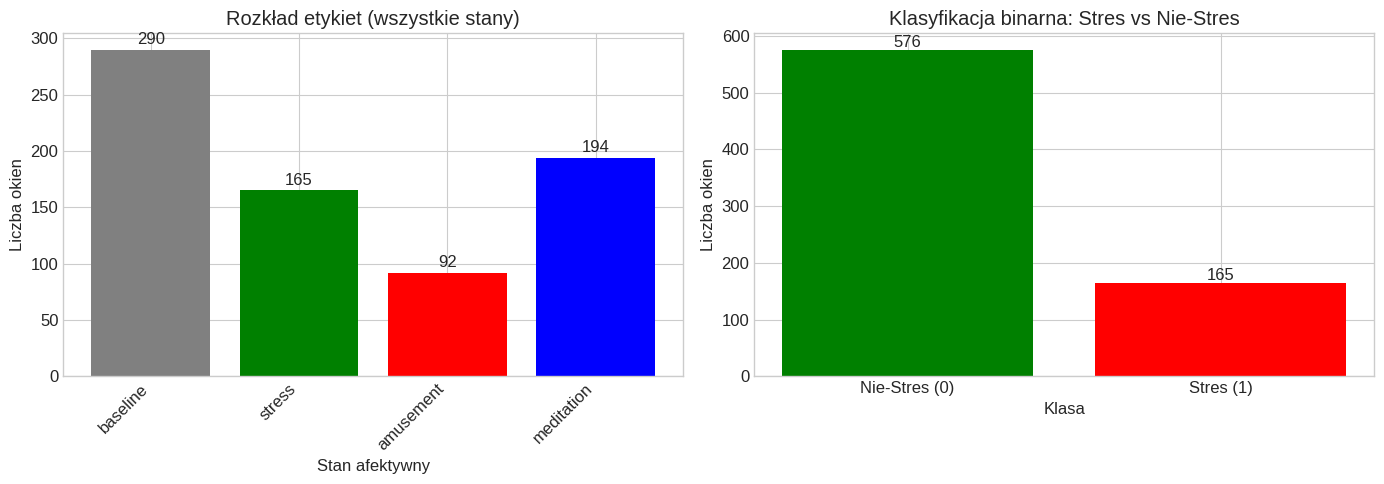


📊 Proporcja klas: 77.7% Nie-Stres, 22.3% Stres


In [13]:
# Rozkład etykiet
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rozszerzone mapowanie dla wszystkich etykiet
LABEL_MAPPING_FULL = {
    0: 'not_defined',
    1: 'baseline',
    2: 'stress',
    3: 'amusement',
    4: 'meditation',
    5: 'transition_1',
    6: 'transition_2',
    7: 'transition_3'
}

# Wszystkie etykiety
label_counts = df_all['label'].value_counts().sort_index()
colors = ['gray', 'green', 'red', 'blue', 'purple', 'orange', 'cyan', 'pink']
labels_names = [LABEL_MAPPING_FULL.get(i, f'unknown_{i}') for i in label_counts.index]

axes[0].bar(labels_names, label_counts.values, color=colors[:len(label_counts)])
axes[0].set_title('Rozkład etykiet (wszystkie stany)')
axes[0].set_xlabel('Stan afektywny')
axes[0].set_ylabel('Liczba okien')
plt.sca(axes[0])
plt.xticks(rotation=45, ha='right')

for i, (name, count) in enumerate(zip(labels_names, label_counts.values)):
    axes[0].text(i, count + 5, str(count), ha='center')

# Klasyfikacja binarna: Stres vs Nie-Stres
df_all['is_stress'] = (df_all['label'] == 2).astype(int)
binary_counts = df_all['is_stress'].value_counts().sort_index()

axes[1].bar(['Nie-Stres (0)', 'Stres (1)'], binary_counts.values, color=['green', 'red'])
axes[1].set_title('Klasyfikacja binarna: Stres vs Nie-Stres')
axes[1].set_xlabel('Klasa')
axes[1].set_ylabel('Liczba okien')

for i, count in enumerate(binary_counts.values):
    axes[1].text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

print(f"\n📊 Proporcja klas: {binary_counts[0]/len(df_all)*100:.1f}% Nie-Stres, {binary_counts[1]/len(df_all)*100:.1f}% Stres")

## 6. Przygotowanie danych do modelowania

In [14]:
# Usunięcie kolumn niebędących cechami
feature_columns = [col for col in df_all.columns if col not in ['label', 'subject', 'window_start', 'is_stress']]

print(f"📋 Cechy używane do klasyfikacji ({len(feature_columns)}):")
for i, col in enumerate(feature_columns, 1):
    print(f"   {i:2d}. {col}")

📋 Cechy używane do klasyfikacji (30):
    1. bvp_mean
    2. bvp_std
    3. hr_mean
    4. hr_std
    5. hr_min
    6. hr_max
    7. hr_range
    8. hrv_rmssd
    9. hrv_sdnn
   10. hrv_mean_rr
   11. hrv_pnn50
   12. eda_mean
   13. eda_std
   14. eda_min
   15. eda_max
   16. eda_range
   17. eda_slope
   18. eda_tonic_mean
   19. eda_tonic_std
   20. eda_phasic_mean
   21. eda_phasic_std
   22. eda_phasic_max
   23. scr_peaks_count
   24. scr_peaks_rate
   25. temp_mean
   26. temp_std
   27. temp_min
   28. temp_max
   29. temp_range
   30. temp_slope


In [15]:
# Obsługa brakujących wartości
print("🔍 Sprawdzenie brakujących wartości:")
missing = df_all[feature_columns].isnull().sum()
print(missing[missing > 0])

# Wypełnienie medianą
df_clean = df_all.copy()
for col in feature_columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

print(f"\n✅ Brakujące wartości uzupełnione medianą")

🔍 Sprawdzenie brakujących wartości:
Series([], dtype: int64)

✅ Brakujące wartości uzupełnione medianą


In [16]:
# Przygotowanie X, y, groups
X = df_clean[feature_columns].values
y = df_clean['label'].values
groups = df_clean['subject'].values  # Do walidacji LOSO

print(f"📊 Wymiary danych:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape}")
print(f"   Unikalne grupy (uczestnicy): {len(np.unique(groups))}")

📊 Wymiary danych:
   X: (741, 30)
   y: (741,)
   Unikalne grupy (uczestnicy): 15


## 7. Wizualizacja korelacji cech

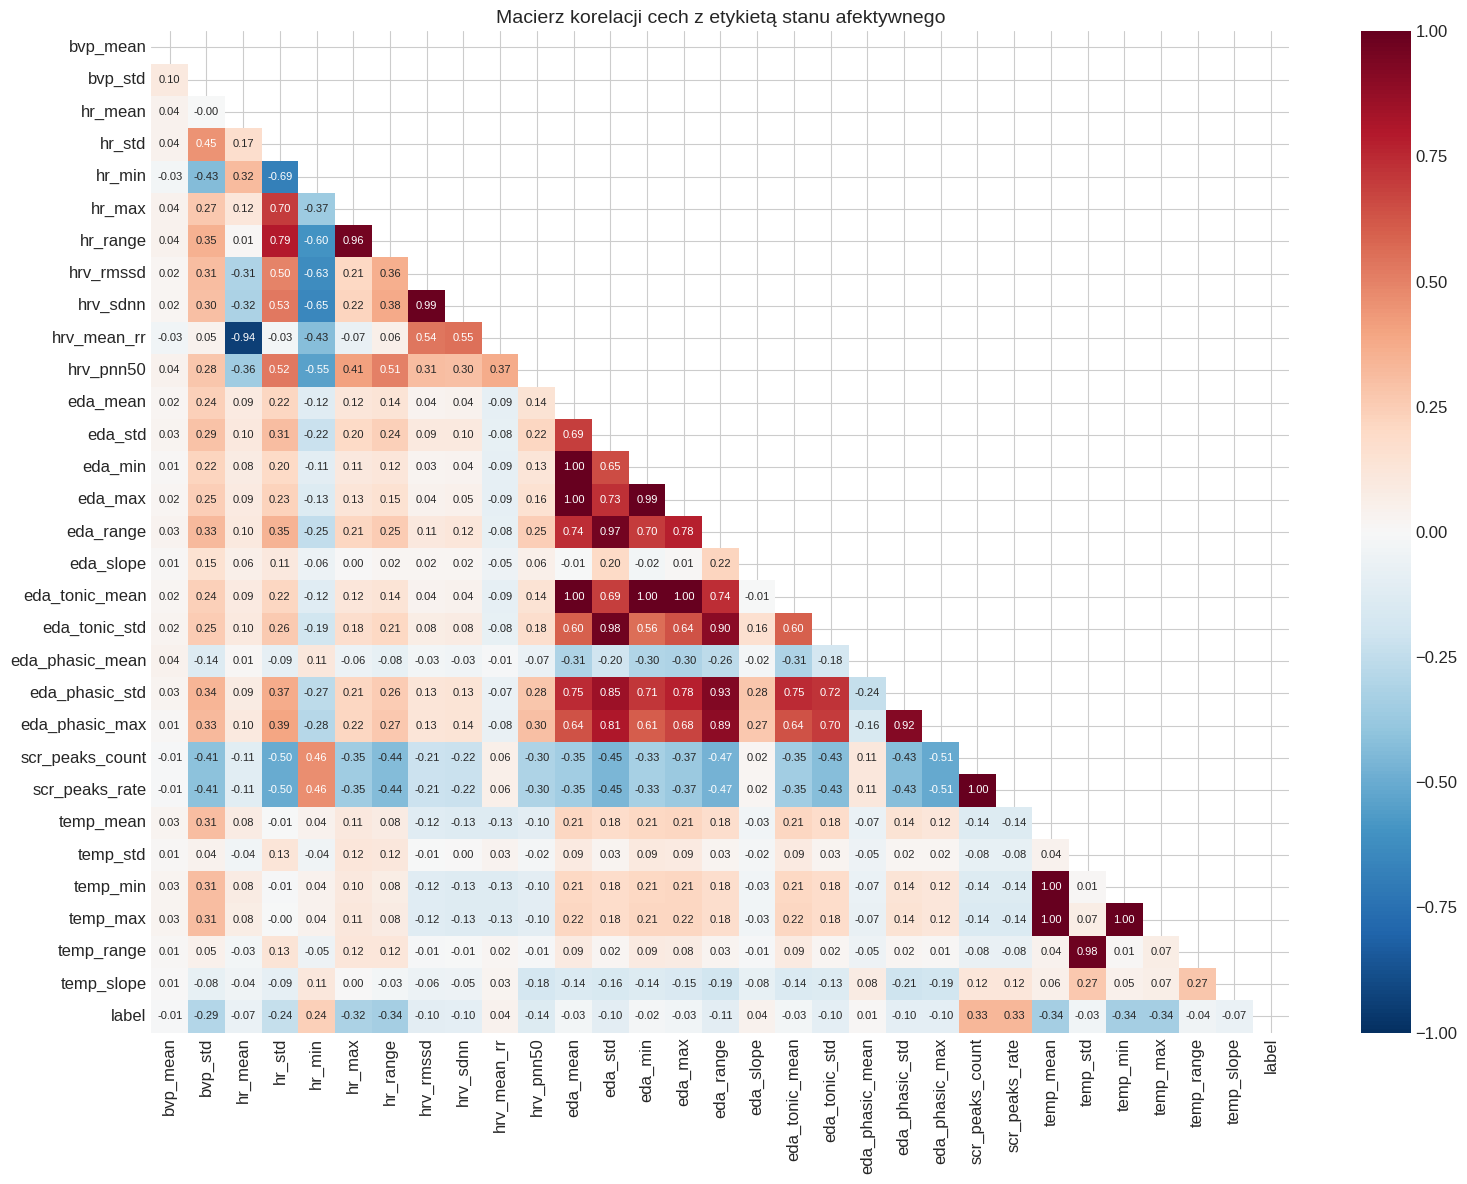


🔥 Korelacja cech ze stanem afektywnym (top 10):
temp_max           0.343074
temp_mean          0.342363
temp_min           0.341539
hr_range           0.341420
scr_peaks_count    0.331555
scr_peaks_rate     0.331555
hr_max             0.317052
bvp_std            0.292778
hr_min             0.240842
hr_std             0.236613
Name: label, dtype: float64


In [17]:
# Macierz korelacji
plt.figure(figsize=(16, 12))
corr_matrix = df_clean[feature_columns + ['label']].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-1, vmax=1, annot_kws={'size': 8})
plt.title('Macierz korelacji cech z etykietą stanu afektywnego', fontsize=14)
plt.tight_layout()
plt.show()

# Najważniejsze korelacje ze stanem afektywnym
print("\n🔥 Korelacja cech ze stanem afektywnym (top 10):")
label_corr = corr_matrix['label'].drop('label').abs().sort_values(ascending=False)
print(label_corr.head(10))

## 8. Modelowanie: Random Forest z walidacją LOSO

**LOSO (Leave-One-Subject-Out)** - trenujemy na N-1 uczestnikach, testujemy na 1. 
To pokazuje, czy model generalizuje na nowe osoby!

In [18]:
# Walidacja Leave-One-Subject-Out
logo = LeaveOneGroupOut()

# Model: Random Forest
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(
        #n_estimators=100,
        #max_depth=10,
        #min_samples_split=5,
        random_state=42,
        #n_jobs=-1,
        class_weight='balanced'  # Obsługa niezbalansowanych klas
    ))
])

print("🔄 Walidacja LOSO (Leave-One-Subject-Out)...\n")

# Predykcje cross-validation
y_pred = cross_val_predict(pipeline, X, y, cv=logo, groups=groups, n_jobs=-1)

print("✅ Walidacja zakończona!")

🔄 Walidacja LOSO (Leave-One-Subject-Out)...

✅ Walidacja zakończona!


In [19]:
label_names = ['baseline', 'stress', 'amusement', 'meditation'] #, 'transition_1', 'transition_2', 'transition_3']

In [20]:
# Wyniki
print("="*60)
print("📊 WYNIKI KLASYFIKACJI")
print("="*60)
print(f"\n🎯 Accuracy: {accuracy_score(y, y_pred)*100:.2f}%")
print(f"🎯 F1-Score (macro): {f1_score(y, y_pred, average='macro')*100:.2f}%")
print(f"🎯 F1-Score (weighted): {f1_score(y, y_pred, average='weighted')*100:.2f}%")

print("\n" + "="*60)
print("📋 Classification Report:")
print("="*60)
print(classification_report(y, y_pred, target_names=label_names))

📊 WYNIKI KLASYFIKACJI

🎯 Accuracy: 62.75%
🎯 F1-Score (macro): 51.25%
🎯 F1-Score (weighted): 59.11%

📋 Classification Report:
              precision    recall  f1-score   support

    baseline       0.62      0.79      0.70       290
      stress       0.77      0.79      0.78       165
   amusement       0.17      0.02      0.04        92
  meditation       0.54      0.53      0.53       194

    accuracy                           0.63       741
   macro avg       0.52      0.53      0.51       741
weighted avg       0.58      0.63      0.59       741



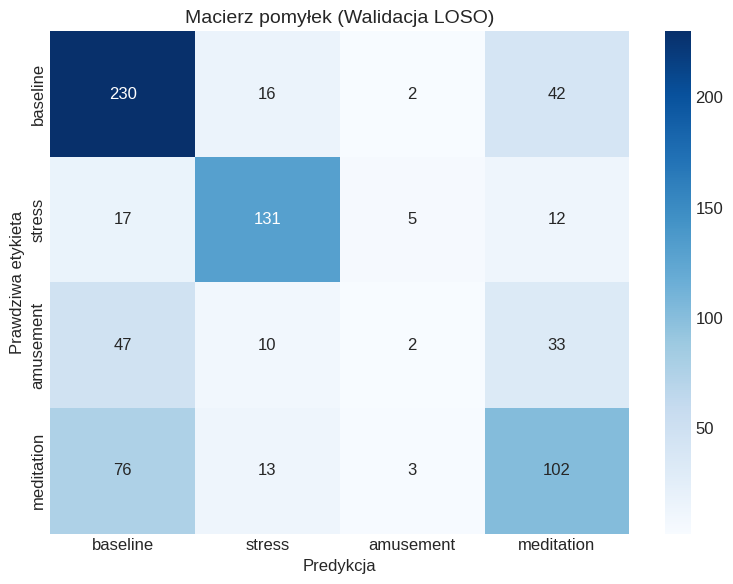

In [21]:
# Macierz pomyłek
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names,
            yticklabels=label_names)
plt.xlabel('Predykcja')
plt.ylabel('Prawdziwa etykieta')
plt.title('Macierz pomyłek (Walidacja LOSO)', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Ważność cech (Feature Importance)

In [22]:
# Trenowanie modelu na całych danych (do analizy ważności cech)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf_model = RandomForestClassifier(
    #n_estimators=100,
    #max_depth=10,
    #min_samples_split=5,
    random_state=42,
    #n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_scaled, y)

# Ważność cech
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("🏆 Top 15 najważniejszych cech:")
print(feature_importance.head(15))

🏆 Top 15 najważniejszych cech:
           feature  importance
3           hr_std    0.071237
27        temp_max    0.052352
1          bvp_std    0.051312
26        temp_min    0.044689
20  eda_phasic_std    0.043829
24       temp_mean    0.043480
15       eda_range    0.038721
2          hr_mean    0.037964
23  scr_peaks_rate    0.037628
17  eda_tonic_mean    0.036330
9      hrv_mean_rr    0.034774
21  eda_phasic_max    0.033743
16       eda_slope    0.032945
7        hrv_rmssd    0.032784
8         hrv_sdnn    0.031813


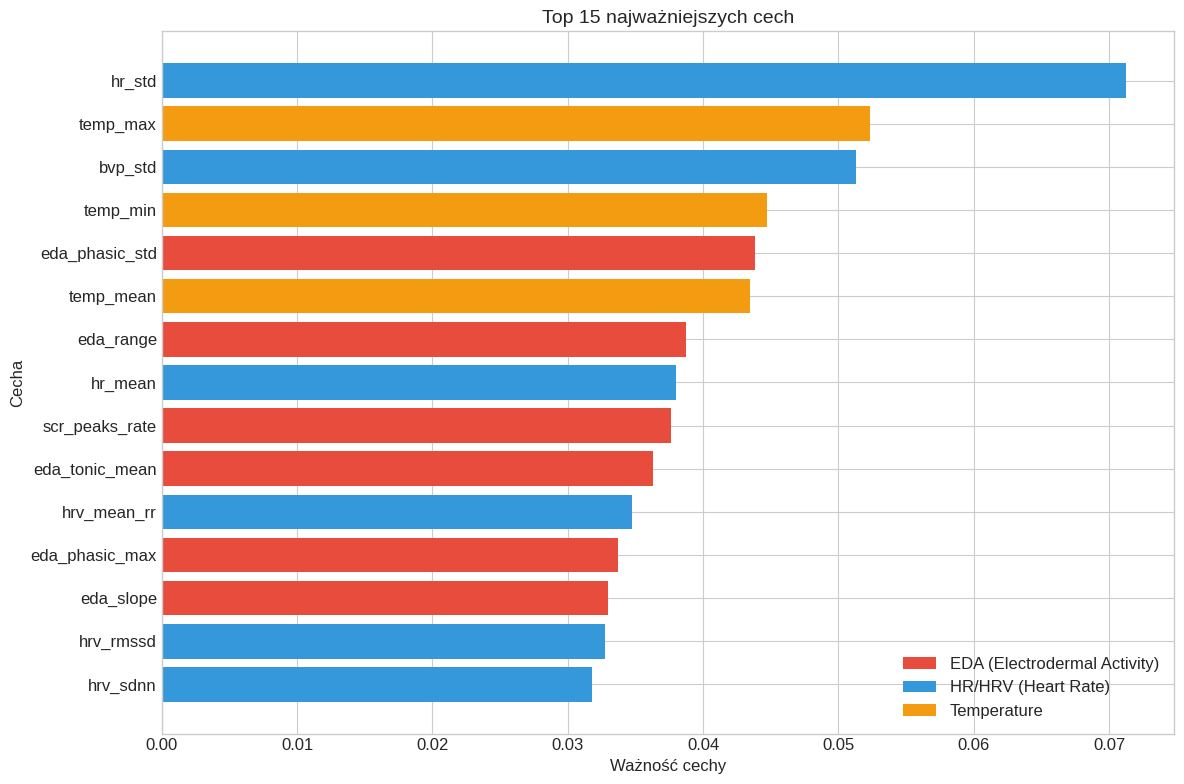

In [23]:
# Wizualizacja ważności cech
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)

colors = ['#e74c3c' if 'eda' in f or 'scr' in f else 
          '#3498db' if 'hr' in f or 'bvp' in f else 
          '#f39c12' for f in top_features['feature']]

bars = plt.barh(top_features['feature'], top_features['importance'], color=colors)
plt.xlabel('Ważność cechy')
plt.ylabel('Cecha')
plt.title('Top 15 najważniejszych cech', fontsize=14)
plt.gca().invert_yaxis()

# Legenda kolorów
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='EDA (Electrodermal Activity)'),
    Patch(facecolor='#3498db', label='HR/HRV (Heart Rate)'),
    Patch(facecolor='#f39c12', label='Temperature')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

## 10. Wyniki dla poszczególnych uczestników

In [24]:
# Szczegółowe wyniki per uczestnik
results_per_subject = []

for train_idx, test_idx in logo.split(X, y, groups):
    subject = groups[test_idx[0]]
    y_true_subj = y[test_idx]
    y_pred_subj = y_pred[test_idx]
    
    acc = accuracy_score(y_true_subj, y_pred_subj)
    f1 = f1_score(y_true_subj, y_pred_subj, average='macro', zero_division=0)
    
    results_per_subject.append({
        'Subject': subject,
        'Accuracy': acc,
        'F1-Score': f1,
        'N_samples': len(test_idx)
    })

df_results = pd.DataFrame(results_per_subject)
df_results = df_results.sort_values('Subject')
print("📊 Wyniki dla poszczególnych uczestników:")
print(df_results.to_string(index=False))

print(f"\n📈 Średnia Accuracy: {df_results['Accuracy'].mean()*100:.2f}% (±{df_results['Accuracy'].std()*100:.2f}%)")
print(f"📈 Średni F1-Score: {df_results['F1-Score'].mean()*100:.2f}% (±{df_results['F1-Score'].std()*100:.2f}%)")

📊 Wyniki dla poszczególnych uczestników:
Subject  Accuracy  F1-Score  N_samples
    S10  0.725490  0.584891         51
    S11  0.784314  0.622926         51
    S13  0.568627  0.378220         51
    S14  0.320000  0.177451         50
    S15  0.653061  0.511466         49
    S16  0.791667  0.694518         48
    S17  0.612245  0.480507         49
     S2  0.562500  0.402614         48
     S3  0.469388  0.401390         49
     S4  0.673469  0.517481         49
     S5  0.680000  0.531579         50
     S6  0.640000  0.539043         50
     S7  0.553191  0.466433         47
     S8  0.583333  0.401732         48
     S9  0.784314  0.604575         51

📈 Średnia Accuracy: 62.68% (±12.72%)
📈 Średni F1-Score: 48.77% (±12.56%)


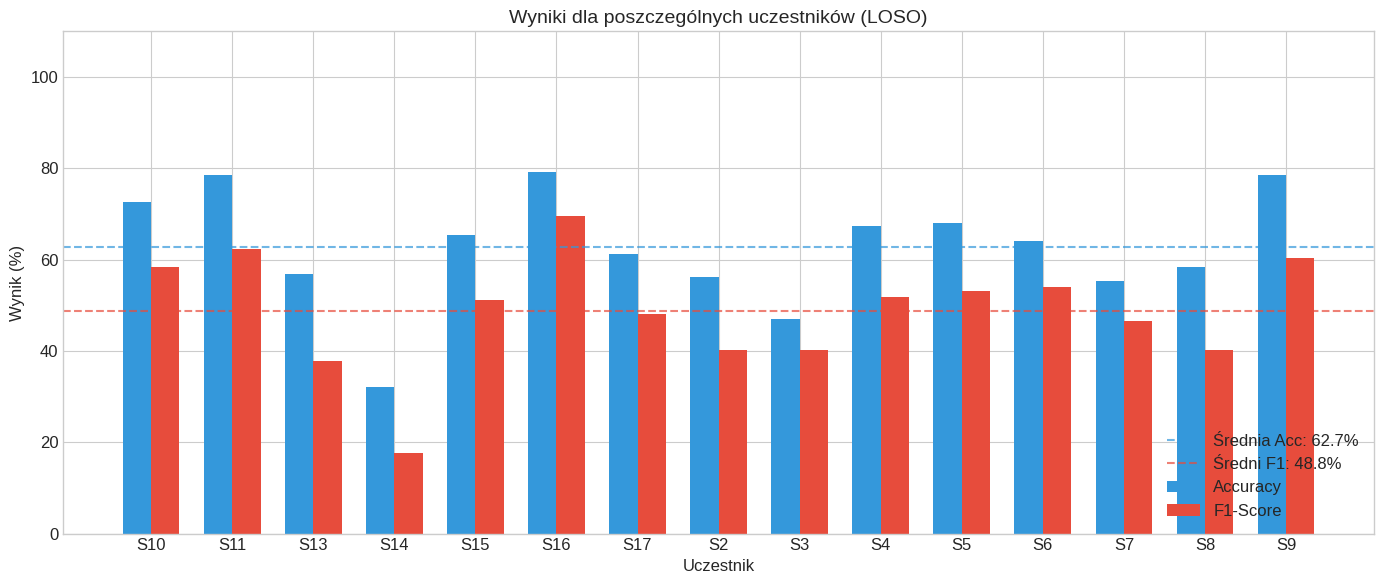

In [25]:
# Wizualizacja wyników per uczestnik
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(df_results))
width = 0.35

bars1 = ax.bar(x - width/2, df_results['Accuracy']*100, width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x + width/2, df_results['F1-Score']*100, width, label='F1-Score', color='#e74c3c')

ax.axhline(y=df_results['Accuracy'].mean()*100, color='#3498db', linestyle='--', alpha=0.7, label=f'Średnia Acc: {df_results["Accuracy"].mean()*100:.1f}%')
ax.axhline(y=df_results['F1-Score'].mean()*100, color='#e74c3c', linestyle='--', alpha=0.7, label=f'Średni F1: {df_results["F1-Score"].mean()*100:.1f}%')

ax.set_xlabel('Uczestnik')
ax.set_ylabel('Wynik (%)')
ax.set_title('Wyniki dla poszczególnych uczestników (LOSO)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(df_results['Subject'])
ax.legend(loc='lower right')
ax.set_ylim(0, 110)

plt.tight_layout()
plt.show()